In [1]:
%load_ext autoreload
%autoreload 2

# Add other paths
import os, sys
sys.path.append(os.path.abspath(os.path.join("../")))
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
import helper_libraries.results_tools as results_tools
import multiprocessing
import functools
import warnings
import scipy.stats
from stargazer import stargazer
from tqdm.auto import tqdm
from numba import jit

warnings.simplefilter("ignore")

# Import data

## Returns and Spreads

In [2]:
# Load returns and spreads
fret_df, hrf_df = results_tools.load_mkt_rf_returns()
spread_df = results_tools.load_spreads()

## Trading

In [3]:
# Year to start trading
start_year = '2004'

# Define strategies and models
strategies_list = [
    "Market",
    "Sign",
    "Positive",
    "Tanh",
    "MS Strategy 2",
    "MS Strategy 1",
]
model_list = [
    "Benchmark",
    "LR",
    "LR_PCA_select",
    "LR_Lasso_select",
    "Lasso",
    "Enet"
]

In [5]:
# Load model results
forecast_oss_df, forecast_ins_df, results_folder_name = results_tools.load_model_results(
    folder_name = 'main'
)

# Filter data
forecast_oss_filter_df = forecast_oss_df.loc[start_year:].copy()
forecast_ins_filter_df = forecast_ins_df.loc[:str(int(start_year)-1)].copy()
fret_filter_df = fret_df.loc[start_year:].copy()
hrf_filter_df = hrf_df.loc[start_year:].copy()

# Trading strategies
(
    oss_results_all_df,
    oss_returns_all_df,
    oss_weights_all_df,
    oss_retpred_all_df,
) = results_tools.get_trading_results(
    forecast_oss_filter_df,
    forecast_ins_filter_df,
    spread_df,
    fret_filter_df["ff__mkt"],
    hrf_filter_df["rf"],
    strategies_list,
    model_list,
    hold_cash=True,
)

## JLN Uncertainty

In [6]:
# Load uncertainty measurse from Jurado, Ludvigson, Ng
uncertainty_financial_df = pd.read_excel('../../data/jln/FinancialUncertaintyToCirculate.xlsx')
uncertainty_macro_df = pd.read_excel('../../data/jln/MacroUncertaintyToCirculate.xlsx')
uncertainty_real_df = pd.read_excel('../../data/jln/RealUncertaintyToCirculate.xlsx')

In [7]:
## Clean up
# Fix date index
uncertainty_financial_df.index = pd.to_datetime(uncertainty_financial_df['Date']) + pd.tseries.offsets.MonthEnd(0)
uncertainty_macro_df.index = pd.to_datetime(uncertainty_macro_df['Date']) + pd.tseries.offsets.MonthEnd(0)
uncertainty_real_df.index = pd.to_datetime(uncertainty_real_df['Date']) + pd.tseries.offsets.MonthEnd(0)

# Setup variables
uncertainty_financial_df['financial_uncertainty'] = uncertainty_financial_df['h=1'] / np.std(uncertainty_financial_df['h=1'])
uncertainty_macro_df['macro_uncertainty'] = uncertainty_macro_df['h=1'] / np.std(uncertainty_macro_df['h=1'])
uncertainty_real_df['real_uncertainty'] = uncertainty_real_df['h=1'] / np.std(uncertainty_real_df['h=1'])

## BEX Uncertainty

In [8]:
# Load uncertainty measurse from Bekaert, Engstrom, Xu
uncertainty_econ_df = pd.read_excel(
    "../../data/bex/BEX_Indices_20220301.xlsx", sheet_name="DATA_PLOT_monthly"
)[["yyyymm", "unc_bex_PAPER"]]
index_ra_df = pd.read_excel(
    "../../data/bex/BEX_Indices_20220301.xlsx", sheet_name="DATA_PLOT_monthly"
)[["yyyymm", "ra_bex_PAPER"]]

In [9]:
## Clean up
# Fix date index
uncertainty_econ_df.index = pd.to_datetime(
    uncertainty_econ_df["yyyymm"], format="%Y%m"
) + pd.tseries.offsets.MonthEnd(0)
index_ra_df.index = pd.to_datetime(
    index_ra_df["yyyymm"], format="%Y%m"
) + pd.tseries.offsets.MonthEnd(0)

# Setup variables
uncertainty_econ_df["bex_uncertainty"] = uncertainty_econ_df["unc_bex_PAPER"] / np.std(
    uncertainty_econ_df["unc_bex_PAPER"]
)
index_ra_df["bex_risk_aversion"] = index_ra_df["ra_bex_PAPER"] / np.std(
    index_ra_df["ra_bex_PAPER"]
)

## FRED

In [10]:
# Load uncertainty measurse from FRED
fred_gdp_df = pd.read_excel(
    "../../data/fred/GDP.xls", skiprows = 10)
fred_unemp_df = pd.read_excel(
    "../../data/fred/UNRATE.xls", skiprows = 10)

In [11]:
## Clean up
# Fix date index
fred_gdp_df.index = pd.to_datetime(
    (pd.to_datetime(fred_gdp_df["observation_date"]) + pd.tseries.offsets.MonthEnd(0)).dt.date
)
fred_gdp_df = fred_gdp_df.drop(['observation_date'], axis=1)

fred_unemp_df.index = pd.to_datetime(
    (pd.to_datetime(fred_unemp_df["observation_date"]) + pd.tseries.offsets.MonthEnd(0)).dt.date
)
fred_unemp_df = fred_unemp_df.drop(['observation_date'], axis=1)

# Setup variables
fred_gdp_df["gdp_growth"] = fred_gdp_df["GDP_PCH"] / np.std(fred_gdp_df["GDP_PCH"])
fred_unemp_df["unemp_change"] = fred_unemp_df["UNRATE_PCH"] / np.std(fred_unemp_df["UNRATE_PCH"])

# Analysis - Return Regressions

## Main strategy

### Prep data

In [12]:
# Select model strat
model = 'Enet'
strategy = 'MS Strategy 1'

<AxesSubplot:xlabel='datetime'>

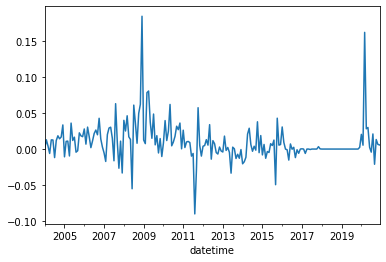

In [13]:
returns_monthly_series = oss_returns_all_df[model][strategy].groupby(pd.Grouper(freq = '1m')).sum()
returns_monthly_diff_series = returns_monthly_series - oss_returns_all_df[model]['Market'].groupby(pd.Grouper(freq = '1m')).sum()
returns_monthly_mkt_series = oss_returns_all_df[model]['Market'].groupby(pd.Grouper(freq = '1m')).sum()
returns_monthly_series.plot()

In [14]:
# Returns
returns_df = (
    returns_monthly_diff_series.to_frame("diff")
    .join(returns_monthly_series.to_frame("returns"))
    .join(returns_monthly_mkt_series.to_frame("mkt"))
)

# Returns with covariates for regressions
reg_df = returns_df.join(uncertainty_financial_df["financial_uncertainty"].shift(-1))
reg_df = reg_df.join(uncertainty_macro_df["macro_uncertainty"].shift(-1))
reg_df = reg_df.join(uncertainty_real_df["real_uncertainty"].shift(-1))
reg_df = reg_df.join(uncertainty_econ_df["bex_uncertainty"].shift(-1))
reg_df = reg_df.join(index_ra_df["bex_risk_aversion"].shift(-1))

### Regressions

In [15]:
fit_fin_mkt = smf.ols("mkt ~ financial_uncertainty", reg_df).fit(
    cov_type="HAC", cov_kwds={"maxlags": 12}
)
fit_fin_diff = smf.ols("diff ~ financial_uncertainty", reg_df).fit(
    cov_type="HAC", cov_kwds={"maxlags": 12}
)
fit_fin_returns = smf.ols("returns ~ financial_uncertainty", reg_df).fit(
    cov_type="HAC", cov_kwds={"maxlags": 12}
)

fit_macro_mkt = smf.ols("mkt ~ macro_uncertainty", reg_df).fit(
    cov_type="HAC", cov_kwds={"maxlags": 12}
)
fit_macro_diff = smf.ols("diff ~ macro_uncertainty", reg_df).fit(
    cov_type="HAC", cov_kwds={"maxlags": 12}
)
fit_macro_returns = smf.ols("returns ~ macro_uncertainty", reg_df).fit(
    cov_type="HAC", cov_kwds={"maxlags": 12}
)

fit_real_mkt = smf.ols("mkt ~ real_uncertainty", reg_df).fit(
    cov_type="HAC", cov_kwds={"maxlags": 12}
)
fit_real_diff = smf.ols("diff ~ real_uncertainty", reg_df).fit(
    cov_type="HAC", cov_kwds={"maxlags": 12}
)
fit_real_returns = smf.ols("returns ~ real_uncertainty", reg_df).fit(
    cov_type="HAC", cov_kwds={"maxlags": 12}
)

fit_all_mkt = smf.ols(
    "mkt ~ financial_uncertainty + macro_uncertainty + real_uncertainty", reg_df
).fit(cov_type="HAC", cov_kwds={"maxlags": 12})
fit_all_diff = smf.ols(
    "diff ~ financial_uncertainty + macro_uncertainty + real_uncertainty", reg_df
).fit(cov_type="HAC", cov_kwds={"maxlags": 12})
fit_all_returns = smf.ols(
    "returns ~ financial_uncertainty + macro_uncertainty + real_uncertainty", reg_df
).fit(cov_type="HAC", cov_kwds={"maxlags": 12})

In [16]:
sg = stargazer.Stargazer([fit_fin_mkt, fit_fin_returns, fit_fin_diff,
                    fit_macro_mkt, fit_macro_returns, fit_macro_diff,
                    fit_real_mkt, fit_real_returns, fit_real_diff,
                    # fit_all_mkt, fit_all_returns, fit_all_diff,
                    ])
sg.column_labels = ['Market', 'ENet-MS1', 'Diff']*3
sg.column_separators = [1]*9
sg.cov_map = {'financial_uncertainty': 'Financial Uncertainty',
              'macro_uncertainty':    'Macro Uncertainty',
              'real_uncertainty':  'Real Uncertainty',}

In [17]:
print(sg.render_latex())

\begin{table}[!htbp] \centering
\begin{tabular}{@{\extracolsep{5pt}}lccccccccc}
\\[-1.8ex]\hline
\hline \\[-1.8ex]
\\[-1.8ex] & \multicolumn{1}{c}{Market} & \multicolumn{1}{c}{ENet-MS1} & \multicolumn{1}{c}{Diff} & \multicolumn{1}{c}{Market} & \multicolumn{1}{c}{ENet-MS1} & \multicolumn{1}{c}{Diff} & \multicolumn{1}{c}{Market} & \multicolumn{1}{c}{ENet-MS1} & \multicolumn{1}{c}{Diff}  \\
\\[-1.8ex] & (1) & (2) & (3) & (4) & (5) & (6) & (7) & (8) & (9) \\
\hline \\[-1.8ex]
 Intercept & 0.023$^{*}$ & -0.029$^{**}$ & -0.053$^{**}$ & 0.016$^{}$ & -0.043$^{***}$ & -0.059$^{**}$ & 0.006$^{}$ & -0.025$^{*}$ & -0.032$^{}$ \\
  & (0.013) & (0.014) & (0.021) & (0.017) & (0.012) & (0.026) & (0.011) & (0.014) & (0.022) \\
 Financial Uncertainty & -0.004$^{}$ & 0.007$^{***}$ & 0.011$^{***}$ & & & & & & \\
  & (0.003) & (0.003) & (0.004) & & & & & & \\
 Macro Uncertainty & & & & -0.002$^{}$ & 0.008$^{***}$ & 0.011$^{**}$ & & & \\
  & & & & (0.003) & (0.002) & (0.004) & & & \\
 Real Uncertainty & & &

## All pairs

In [18]:
def run_reg(reg_df, lhs_var, rhs_var):
    
    fit = smf.ols(f"{lhs_var} ~ {rhs_var}", reg_df).fit(
        cov_type="HAC", cov_kwds={"maxlags": 12}
    )
    
    # Deal with gdp being lower freq
    if 'gdp_growth' in rhs_var:
        reg_alt_df = reg_df.fillna(0)[[lhs_var, rhs_var]].groupby(pd.Grouper(freq = '3m')).sum()
        fit = smf.ols(f"{lhs_var} ~ {rhs_var}", reg_alt_df).fit(
            cov_type="HAC", cov_kwds={"maxlags": 4}
        )
    
    
    return fit

In [69]:
# Params
strategy = "MS Strategy 1"

# Results storage
regressor_name_list = [
    "Financial Uncertainty",
    "Macro Uncertainty",
    "Real Uncertainty",
    "Econ Uncertainty",
    "Risk Aversion",
    "GDP Growth",
    "Unemployment Change",
]
regressor_list = [
    "financial_uncertainty",
    "macro_uncertainty",
    "real_uncertainty",
    "bex_uncertainty",
    "bex_risk_aversion",
    "gdp_growth",
    "unemp_change",
]
results_params_df = pd.DataFrame([], columns=model_list, index=regressor_name_list)
results_tstats_df = pd.DataFrame([], columns=model_list, index=regressor_name_list)
results_r2_df = pd.DataFrame([], columns=model_list, index=regressor_name_list)

for model in tqdm(model_list):

    returns_monthly_series = (
        oss_returns_all_df[model][strategy].groupby(pd.Grouper(freq="1m")).sum()
    )
    returns_monthly_diff_series = (
        returns_monthly_series
        - oss_returns_all_df[model]["Market"].groupby(pd.Grouper(freq="1m")).sum()
    )
    returns_monthly_mkt_series = (
        oss_returns_all_df[model]["Market"].groupby(pd.Grouper(freq="1m")).sum()
    )

    # Returns
    returns_df = (
        returns_monthly_diff_series.to_frame("diff")
        .join(returns_monthly_series.to_frame("returns"))
        .join(returns_monthly_mkt_series.to_frame("mkt"))
    )

    # Returns with covariates for regressions
    reg_df = returns_df.join(uncertainty_financial_df["financial_uncertainty"].shift(-1))
    reg_df = reg_df.join(uncertainty_macro_df["macro_uncertainty"].shift(-1))
    reg_df = reg_df.join(uncertainty_real_df["real_uncertainty"].shift(-1))
    reg_df = reg_df.join(uncertainty_econ_df["bex_uncertainty"].shift(-1))
    reg_df = reg_df.join(index_ra_df["bex_risk_aversion"].shift(-1))
    reg_df = reg_df.join(fred_gdp_df["gdp_growth"].shift(3))
    reg_df = reg_df.join(fred_unemp_df["unemp_change"].shift(1))

    # Regressions
    for i in range(len(regressor_list)):
        
        fit = run_reg(reg_df, 'returns', regressor_list[i])
        results_params_df.loc[regressor_name_list[i], model] = fit.params[-1]
        results_tstats_df.loc[regressor_name_list[i], model] = fit.tvalues[-1]
        results_r2_df.loc[regressor_name_list[i], model] = fit.rsquared
        
        # Regression for the market
        fit = run_reg(reg_df, 'mkt', regressor_list[i])
        results_params_df.loc[regressor_name_list[i], 'Market'] = fit.params[-1]
        results_tstats_df.loc[regressor_name_list[i], 'Market'] = fit.tvalues[-1]
        results_r2_df.loc[regressor_name_list[i], 'Market'] = fit.rsquared
        
# Fix types
results_params_df = results_params_df.astype(float) 
results_tstats_df = results_tstats_df.astype(float) 
results_r2_df = results_r2_df.astype(float) 

  0%|          | 0/6 [00:00<?, ?it/s]

In [108]:
results_params_out_df = results_params_df.drop(['GDP Growth', 'Unemployment Change'])[['Market', 'Lasso', 'Enet']]
print(results_params_out_df.round(4).to_latex(float_format = "{:.2%}".format))

\begin{tabular}{lrrr}
\toprule
{} &  Market &  Lasso &  Enet \\
\midrule
Financial Uncertainty &  -0.42\% &  0.82\% & 0.73\% \\
Macro Uncertainty     &  -0.24\% &  0.86\% & 0.84\% \\
Real Uncertainty      &  -0.08\% &  0.62\% & 0.57\% \\
Econ Uncertainty      &  -0.64\% &  0.86\% & 0.78\% \\
Risk Aversion         &  -0.69\% &  0.74\% & 0.62\% \\
\bottomrule
\end{tabular}



In [109]:
results_tstats_out_df = results_tstats_df.drop(['GDP Growth', 'Unemployment Change'])[['Market', 'Lasso', 'Enet']]
print(results_tstats_out_df.round(2).to_latex())

\begin{tabular}{lrrr}
\toprule
{} &  Market &  Lasso &  Enet \\
\midrule
Financial Uncertainty &   -1.55 &   3.48 &  2.66 \\
Macro Uncertainty     &   -0.81 &   4.36 &  3.92 \\
Real Uncertainty      &   -0.42 &   2.69 &  2.33 \\
Econ Uncertainty      &   -2.52 &   4.62 &  3.55 \\
Risk Aversion         &   -3.62 &   3.62 &  2.53 \\
\bottomrule
\end{tabular}



In [110]:
results_r2_out_df = results_r2_df.drop(['GDP Growth', 'Unemployment Change'])[['Market', 'Lasso', 'Enet']]
print(results_r2_out_df.round(4).to_latex(float_format = "{:.2%}".format))

\begin{tabular}{lrrr}
\toprule
{} &  Market &  Lasso &   Enet \\
\midrule
Financial Uncertainty &   2.15\% & 14.55\% & 11.04\% \\
Macro Uncertainty     &   0.88\% & 20.13\% & 18.39\% \\
Real Uncertainty      &   0.12\% & 12.06\% &  9.59\% \\
Econ Uncertainty      &   4.20\% & 13.22\% & 10.68\% \\
Risk Aversion         &   6.26\% & 12.63\% &  8.56\% \\
\bottomrule
\end{tabular}



In [112]:
results_all_out_df = pd.concat(
    [
        results_params_out_df.applymap(lambda x: f"{x:.2%}"),
        results_tstats_out_df.applymap(lambda x: f"{x:.2f}"),
        results_r2_out_df.applymap(lambda x: f"{x:.1%}"),
    ],
    axis=1,
)
results_all_out_df.columns = pd.MultiIndex.from_arrays(
    [["beta"] * 3 + ["t"] * 3 + ["R2"] * 3, results_all_out_df.columns]
)
print(results_all_out_df.to_latex())

\begin{tabular}{llllllllll}
\toprule
{} & \multicolumn{3}{l}{beta} & \multicolumn{3}{l}{t} & \multicolumn{3}{l}{R2} \\
{} &  Market &  Lasso &   Enet & Market & Lasso &  Enet & Market &  Lasso &   Enet \\
\midrule
Financial Uncertainty &  -0.42\% &  0.82\% &  0.73\% &  -1.55 &  3.48 &  2.66 &   2.1\% &  14.5\% &  11.0\% \\
Macro Uncertainty     &  -0.24\% &  0.86\% &  0.84\% &  -0.81 &  4.36 &  3.92 &   0.9\% &  20.1\% &  18.4\% \\
Real Uncertainty      &  -0.08\% &  0.62\% &  0.57\% &  -0.42 &  2.69 &  2.33 &   0.1\% &  12.1\% &   9.6\% \\
Econ Uncertainty      &  -0.64\% &  0.86\% &  0.78\% &  -2.52 &  4.62 &  3.55 &   4.2\% &  13.2\% &  10.7\% \\
Risk Aversion         &  -0.69\% &  0.74\% &  0.62\% &  -3.62 &  3.62 &  2.53 &   6.3\% &  12.6\% &   8.6\% \\
\bottomrule
\end{tabular}



# Analysis - Predictabiltiy

## Main strategy

### Prep data

In [30]:
# Select model strat
model = 'Enet'
strategy = 'MS Strategy 1'

In [170]:
# Intersection of indices for ff market returns and predictions
index_intersect = np.sort(list(set(oss_retpred_all_df.index).intersection(fret_df.index)))

# Dataframe with prediction residual
resid_df = (
    oss_retpred_all_df.loc[index_intersect][model] - fret_df.loc[index_intersect]["ff__mkt"]
).to_frame("resid")
resid_df["ff__mkt"] = fret_df["ff__mkt"]
resid_df["Date"] = pd.to_datetime(
    (pd.Series(resid_df.index) + pd.tseries.offsets.MonthEnd(0)).dt.date
).values

In [172]:
# Add covariates
resid_df = (
    resid_df.merge(
        uncertainty_financial_df["financial_uncertainty"].shift(-1).reset_index(), how="left", on="Date"
    )
    .merge(uncertainty_macro_df["macro_uncertainty"].shift(-1).reset_index(), how="left", on="Date")
    .merge(uncertainty_real_df["real_uncertainty"].shift(-1).reset_index(), how="left", on="Date")
    .merge(
        uncertainty_econ_df["bex_uncertainty"].shift(-1).reset_index(),
        how="left",
        left_on="Date",
        right_on="yyyymm",
    )
    .drop(["yyyymm"], axis=1)
    .merge(
        index_ra_df["bex_risk_aversion"].shift(-1).reset_index(),
        how="left",
        left_on="Date",
        right_on="yyyymm",
    )
    .drop(["yyyymm"], axis=1)
    .merge(
        fred_gdp_df["gdp_growth"].shift(3).reset_index(),
        how="left",
        left_on="Date",
        right_on="observation_date",
    )
    .drop(["observation_date"], axis=1)
    .merge(
        fred_unemp_df["unemp_change"].shift(1).reset_index(),
        how="left",
        left_on="Date",
        right_on="observation_date",
    )
    .drop(["observation_date"], axis=1)
)

### Get Results

In [308]:
# Regressors
regressor_name_list = [
    "Financial Uncertainty",
    "Macro Uncertainty",
    "Real Uncertainty",
    "Econ Uncertainty",
    "Risk Aversion",
    "GDP Growth",
    "Unemployment Change",
]
regressor_list = [
    "financial_uncertainty",
    "macro_uncertainty",
    "real_uncertainty",
    "bex_uncertainty",
    "bex_risk_aversion",
    "gdp_growth",
    "unemp_change",
]

In [309]:
@jit(nopython=True)
def compute_r2_diff(resid_data):
    
    ss_below = np.sum(np.square(resid_data[resid_data[:, -1] == 0, :2]), axis=0)
    ss_above = np.sum(np.square(resid_data[resid_data[:, -1] == 1, :2]), axis=0)
    r2_above = 1 - ss_above[0] / ss_above[1]
    r2_below = 1 - ss_below[0] / ss_below[1]
    r2_diff = r2_above - r2_below
    
    return r2_above, r2_below, r2_diff

In [313]:
# Results storage
results_list = []

for i in range(len(regressor_name_list)):

    # Set up indicator variable for median
    resid_df[regressor_list[i] + "_above_median"] = (
        resid_df[regressor_list[i]] > resid_df[regressor_list[i]].median()
    ).astype(int)

    # Compare R2
    resid_regressor_agg_df = resid_df.groupby(regressor_list[i] + "_above_median")[
        ["resid", "ff__mkt"]
    ].apply(lambda x: np.sum(np.square(x)))
    result = 1 - resid_regressor_agg_df["resid"] / resid_regressor_agg_df["ff__mkt"]
    result.index = result.index.astype(str)
    
    # Significance
    results_mc_list = []
    resid_df_values = resid_df[['resid', 'ff__mkt', regressor_list[i] + "_above_median"]].values
    for t in tqdm(range(500)):
        resid_data = resid_df_values[np.random.choice(len(resid_df), int(len(resid_df)*0.999)),:]
        r2_above, r2_below, r2_diff = compute_r2_diff(resid_data)
        results_mc_list.append(r2_diff)

    result['p'] = np.mean(np.array(results_mc_list) > 0)
        
    results_list.append(result)

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [314]:
results_df = pd.DataFrame(results_list, index = regressor_name_list)
results_df['Difference'] = results_df['1'] - results_df['0']
results_df

,0,1,p,Difference
Financial Uncertainty,0.000313,0.000772,0.878,0.000459
Macro Uncertainty,0.000238,0.000850,0.968,0.000612
Real Uncertainty,0.000459,0.000767,0.808,0.000309
Econ Uncertainty,0.000639,0.000692,0.590,0.000053
Risk Aversion,0.000308,0.000783,0.904,0.000475
GDP Growth,0.000698,0.000534,0.332,-0.000165
Unemployment Change,0.000497,0.000996,0.922,0.000499
